# Train a online portfolio

In [1]:
import jax.numpy as jnp
import jax
import optax
import polars as pl
import polars.selectors as cs

from pyfoliopt.loss import neg_logdot_loss

In [84]:
import pandas as pd
import yfinance as yf

data: pd.DataFrame = yf.download("BTC-USD ETH-USD", start="2017-01-01", end="2019-01-01")["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

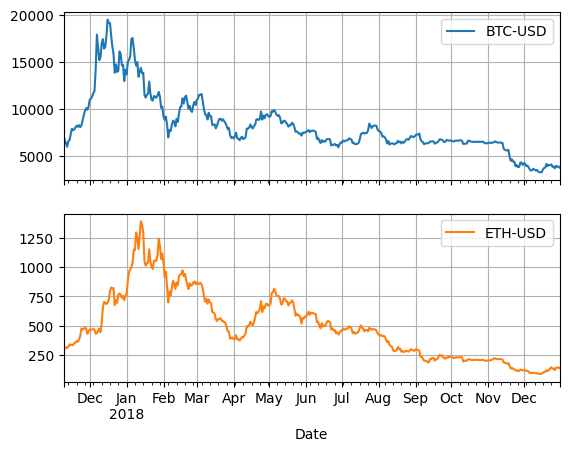

In [85]:
data.plot(grid=True, subplots=True)

In [75]:
df_prices = pl.from_dataframe(data.reset_index()) 
df_prices

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2023-01-01 00:00:00 UTC,16625.080078,1200.964844
2023-01-02 00:00:00 UTC,16688.470703,1214.656616
2023-01-03 00:00:00 UTC,16679.857422,1214.778809
2023-01-04 00:00:00 UTC,16863.238281,1256.526611
2023-01-05 00:00:00 UTC,16836.736328,1250.438599
…,…,…
2024-10-05 00:00:00 UTC,62089.949219,2415.631836
2024-10-06 00:00:00 UTC,62818.953125,2439.957764
2024-10-07 00:00:00 UTC,62236.660156,2421.796631


In [76]:
df_returns = (
    df_prices
    .select(
        cs.datetime(),
        pl.col("BTC-USD").pct_change().alias("BTC-USD_long"),
        pl.col("ETH-USD").pct_change().mul(-1).alias("ETH-USD_short")
    )
)
df_returns

Date,BTC-USD_long,ETH-USD_short
"datetime[ns, UTC]",f64,f64
2023-01-01 00:00:00 UTC,null,null
2023-01-02 00:00:00 UTC,0.003813,-0.011401
2023-01-03 00:00:00 UTC,-0.000516,-0.000101
2023-01-04 00:00:00 UTC,0.010994,-0.034367
2023-01-05 00:00:00 UTC,-0.001572,0.004845
…,…,…
2024-10-05 00:00:00 UTC,0.000362,-0.000347
2024-10-06 00:00:00 UTC,0.011741,-0.01007
2024-10-07 00:00:00 UTC,-0.009269,0.007443


<Axes: xlabel='Date'>

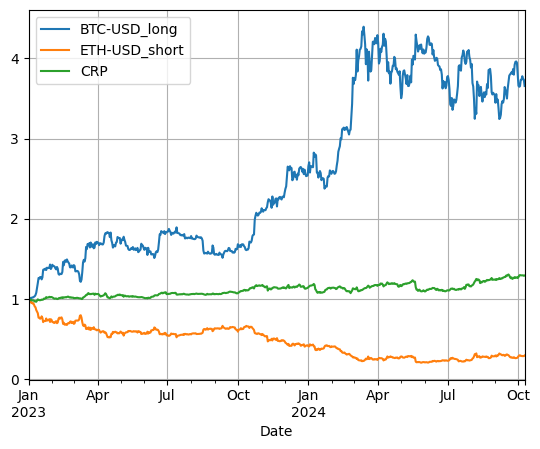

In [79]:
(
    df_returns
    .with_columns(
        CRP = pl.col("BTC-USD_long") * 0.5 + pl.col("ETH-USD_short") * 0.5,
    )
    .select(cs.datetime(), cs.numeric().add(1).cum_prod())
    .to_pandas()
    .set_index("Date")
    .plot(grid=True)
)

In [58]:
- jnp.log(df_prices).cumsum(axis=0)

Array([[  0.6628306,   1.653559 ],
       [  2.9919927,   1.6857347],
       [  3.2601318,   1.7646097],
       ...,
       [604.62756  , 196.30913  ],
       [605.4293   , 196.75438  ],
       [605.7972   , 196.9384   ]], dtype=float32)

In [59]:
jnp.array(values).cumsum()

Array([  1.0402141,   1.6734705,   1.8421652,   1.8222263,   2.4215765,
         2.4417183,   2.9878547,   3.0397558,   2.9491262,   3.6524537,
         3.7549627,   3.5772777,   3.390634 ,   3.1769707,   3.001372 ,
         2.7735934,   2.4957285,   3.255474 ,   3.8282456,   4.7354016,
         5.236225 ,   5.503893 ,   7.0849514,   8.881844 ,   9.392273 ,
        10.456017 ,  10.274806 ,  10.015346 ,   9.944023 ,  10.489742 ,
        11.561411 ,  12.890287 ,  12.798098 ,  12.578016 ,  13.124566 ,
        13.166586 ,  13.254702 ,  13.606258 ,  13.609886 ,  13.668019 ,
        14.294623 ,  14.860333 ,  15.539044 ,  15.327673 ,  15.3773365,
        15.659671 ,  16.167686 ,  17.914677 ,  17.924538 ,  17.94971  ,
        17.749325 ,  18.413673 ,  19.891054 ,  20.239845 ,  20.808924 ,
        20.610668 ,  20.366056 ,  21.125988 ,  21.198217 ,  21.109386 ,
        21.128742 ,  21.167757 ,  21.66694  ,  21.953674 ,  21.849733 ,
        22.25342  ,  21.848263 ,  22.683311 ,  22.924152 ,  22.6

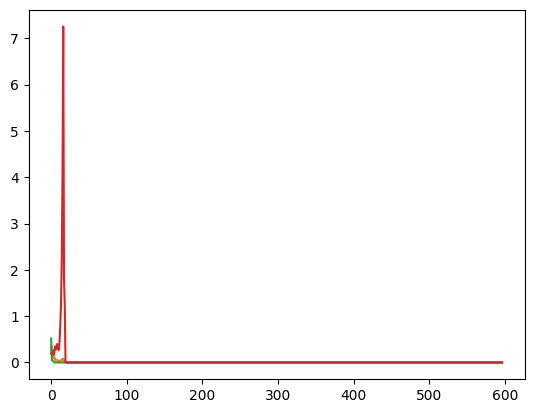

In [52]:
import matplotlib.pyplot as plt

returns = jnp.concat([jnp.array(values).reshape(-1, 1), df_prices.mean(axis=-1, keepdims=True),  df_prices], axis=-1)
plt.plot(returns.cumprod(axis=0))

In [61]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Objective function
def objective(x, r):
    return -np.sum(np.log(r @ x))

# Gradient of the objective function
def gradient(x, r):
    return -np.sum(r / (r @ x)[:, np.newaxis], axis=0)

# Constraint: sum of weights = 1
def constraint(x):
    return np.sum(x) - 1

# Create returns that will yield the desired solution (0.25, 0.75)
np.random.seed(42)
n_periods = 10000
r1 = np.random.normal(1.02, 0.1, n_periods)  # Asset 1 returns
r2 = np.random.normal(1.06, 0.1, n_periods)  # Asset 2 returns
r = np.column_stack((r1, r2))

# Ensure the expected solution is (0.25, 0.75)
harmonic_mean1 = 1 / np.mean(1/r1)
harmonic_mean2 = 1 / np.mean(1/r2)
assert np.isclose(0.25, harmonic_mean2 / (harmonic_mean1 + harmonic_mean2), atol=1e-2)
assert np.isclose(0.75, harmonic_mean1 / (harmonic_mean1 + harmonic_mean2), atol=1e-2)

# Calculate analytical solution
analytical_solution = (1/np.mean(1/r, axis=0)) / np.sum(1/np.mean(1/r, axis=0))
print(f"Analytical solution: {analytical_solution}")

# Optimize using SciPy
x0 = np.array([0.5, 0.5])  # Initial guess
cons = ({'type': 'eq', 'fun': constraint})
bounds = [(0, 1), (0, 1)]

result = minimize(objective, x0, args=(r,), method='SLSQP', jac=gradient,
                  bounds=bounds, constraints=cons, options={'ftol': 1e-9, 'disp': True})

print(f"Optimal weights (SciPy): {result.x}")
print(f"Objective value: {-result.fun}")

# Visualize the optimization landscape
x1 = np.linspace(0, 1, 100)
x2 = 1 - x1
z = np.array([objective(np.array([xi, 1-xi]), r) for xi in x1])

plt.figure(figsize=(10, 6))
plt.plot(x1, -z)
plt.scatter(result.x[0], -result.fun, color='red', s=100, label='Optimal (numerical)')
plt.scatter(analytical_solution[0], -objective(analytical_solution, r), color='green', s=100, label='Optimal (analytical)')
plt.axvline(x=0.25, color='gray', linestyle='--', label='Target solution')
plt.xlabel('Weight of Asset 1')
plt.ylabel('Objective Value')
plt.title('Optimization Landscape')
plt.legend()
plt.grid(True)
plt.show()

# Simulate portfolio performance
n_simulations = 10000
portfolio_returns = np.zeros(n_simulations)
for i in range(n_simulations):
    r1_sim = np.random.normal(1.02, 0.1)
    r2_sim = np.random.normal(1.06, 0.1)
    portfolio_returns[i] = 0.25 * r1_sim + 0.75 * r2_sim

print(f"Expected portfolio return: {np.mean(portfolio_returns)}")
print(f"Portfolio return std dev: {np.std(portfolio_returns)}")

plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.7)
plt.axvline(np.mean(portfolio_returns), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.xlabel('Portfolio Return')
plt.ylabel('Density')
plt.title('Distribution of Portfolio Returns')
plt.legend()
plt.grid(True)
plt.show()

AssertionError: 